In [1]:
# Importing libs
import re
import nltk
import transformers
import gensim.downloader as gensim_api
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, manifold

In [39]:
# Read data
dtf = pd.read_json('data.json', lines=True)
dtf.head()

,subreddit,id,title,score,upvote_ratio,url,comment_1,comment_2,comment_3,score_c1,score_c2,score_c3
0,nottheonion,l7afyx,People Are Accusing Robinhood Of Stealing From...,181832,0.95,https://www.buzzfeednews.com/article/clarissaj...,Not only did Robinhood move the goalposts when...,a class action lawsuit has been filed. further...,"Basically, Robinhood just stated that your acc...",15245,14359,5337
1,nottheonion,gyzw2p,US Military Could Lose Space Force Trademark t...,130123,0.91,https://www.cbr.com/us-military-lose-space-for...,Please please PLEASE let this happen. The wor...,"In US trademark law it's first to use, not fir...","It sounds silly, but some years ago the UK pol...",12325,11535,5548
2,nottheonion,jrskag,White House threatens to fire anyone who tries...,127328,0.89,https://americanindependent.com/white-house-th...,The penalty for attempted suicide is death,Daily beatings will continue until morale impr...,"From what I understood, they said anyone that ...",24384,19378,12375
3,nottheonion,so0ree,Meta's threat to close down Facebook and Insta...,127326,0.95,https://www.cityam.com/metas-threat-to-close-d...,"Hey guys - while you’re at it, please shut it ...",750 million people in Europe. Even Zucky won't...,As much as I agree with politicians who say li...,18527,17604,6989
4,nottheonion,g6zci5,Don't eat or inject yourself with disinfectant...,126247,0.94,https://www.cnn.com/world/live-news/coronaviru...,"I'll take ""Shit I never thought would be a hea...",Tide Pod Challenge - White House Edition,I just got a letter from my georgia congressma...,23444,12429,6640


In [40]:
# Get the "title" column
dtf = dtf[['title']]
dtf.head(5)

,title
0,People Are Accusing Robinhood Of Stealing From...
1,US Military Could Lose Space Force Trademark t...
2,White House threatens to fire anyone who tries...
3,Meta's threat to close down Facebook and Insta...
4,Don't eat or inject yourself with disinfectant...


In [4]:
# Text preprocessing
def preprocess_text(text, stemm=False, lemm=True, stopwords=None):
    # Remove punctuations, lowercase, strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize
    texts = text.split()    
    # Remove Stopwords
    if stopwords is not None:
        texts = [word for word in texts if word not in stopwords]
                
    # Stemming
    if stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        texts = [ps.stem(word) for word in texts]
                
    # Lemmatisation
    if lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        texts = [lem.lemmatize(word) for word in texts]
            
    # Collect lists
    text = " ".join(texts)
    return text

In [5]:
# Loading stopwords dict
stopwords = nltk.corpus.stopwords.words("english")

In [6]:
# Doint preprocessing on texts
clean_data = dtf["title"].apply(lambda x: 
          preprocess_text(x, stemm=False, lemm=True, stopwords=stopwords))
clean_data.head()

0    people accusing robinhood stealing poor give r...
1    u military could lose space force trademark ne...
2           white house threatens fire anyone try quit
3    metas threat close facebook instagram europe b...
4    dont eat inject disinfectant warns fda commiss...
Name: title, dtype: object

In [7]:
# Loading glove-twitter-200 model
glove_twitter_200 = gensim_api.load('glove-twitter-200')
#gensim_api.info()

In [9]:
# Get semantically similiar words by using most_similar method
def most_similar_method(input_words, amount, model):

    # Words we would like to dodge
    unwanted = ['risk','charges','death','charged','child','after','should','’s','against','not','that','should','threat']

    # Saving given words
    final_words = input_words

    # Adding created words to the list
    for topn_words in model.most_similar(input_words, topn=amount):
        if topn_words[0] not in unwanted:
            final_words.append(topn_words[0])
    return list(set(final_words))

## Create Dictionary {category:[keywords]}
target_topics = {}

target_topics["HEALTH"] = most_similar_method(['vaccine', 'hospital', 'disease', 'respiratory',
                    'drug', 'pandemic', 'health'], amount=20, model=glove_twitter_200)
target_topics["CRIMES"] = most_similar_method(['police', 'shoot', 'arrest', 'officer',
                    'murder', 'dead', 'prison', 'jail'], amount=20, model=glove_twitter_200)
target_topics["POLITICS"] = most_similar_method(['trump', 'president', 'russia', 'russian', 'leader',
                    'election', 'threat', 'legal', 'law', 'politic'], amount=20, model=glove_twitter_200)
target_topics["ECONOMY"] = most_similar_method(['tax', 'money', 'budget', 'investment',
                    'cost', 'profit'], amount=30, model=glove_twitter_200)

# Remove specific words from specific dicts
target_topics["ECONOMY"].remove('government')

# Check the result
for k,v in target_topics.items():
    print(k, ": ", v[:])

HEALTH :  ['hiv', 'drug', 'aids', 'health', 'infection', 'disease', 'hospital', 'diagnosis', 'treatment', 'symptoms', 'clinical', 'obesity', 'prevention', 'respiratory', 'pandemic', 'healthcare', 'patients', 'illness', 'asthma', 'chronic', 'medical', 'doctors', 'research', 'diseases', 'vaccine', 'diabetes']
CRIMES :  ['caught', 'rape', 'police', 'shooting', 'officers', 'killed', 'prison', 'jail', 'cop', 'shot', 'accused', 'suspect', 'cops', 'murder', 'kill', 'arrested', 'dead', 'arrest', 'shoot', 'killing', 'officer', 'court']
POLITICS :  ['claims', 'president', 'politics', 'rights', 'russian', 'law', 'government', 'says', 'political', 'leaders', 'govt', 'minister', 'leader', 'threat', 'politic', 'states', 'policy', 'state', 'russia', 'legal', 'obama', 'election', 'gov', 'u.s.', 'trump']
ECONOMY :  ['business', 'cash', 'funds', 'dollars', 'property', 'companies', 'corporate', 'paying', 'paid', 'profit', 'finance', 'budget', 'fund', 'pay', 'company', 'revenue', 'costs', 'funding', 'inco

c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\sorok\AppData\Local\Temp\ipykernel_10024\3921761513.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vis_df = vis_df.append(vis_df_group)
C:\Users\sorok\AppData\Local\Temp\ipykernel_10024\3921761513.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vis_df = vis_df.append(vis_df_group)
C:\Users\sorok\AppData\Local\Temp

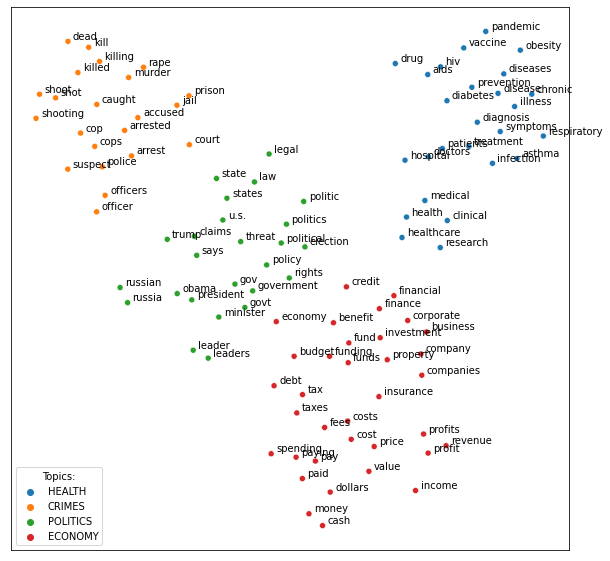

In [20]:
# Word embedding
embed_words = [word for x in target_topics.values() for word in x]
vectors_glove_twitter_200 = glove_twitter_200[embed_words]
        
# PCA
pca = manifold.TSNE(perplexity=20, n_components=2, init='pca', random_state=20)
vectors_glove_twitter_200 = pca.fit_transform(vectors_glove_twitter_200)

# Create dtf
vis_df = pd.DataFrame()
for k,v in target_topics.items():
    size = len(vis_df) + len(v)
    vis_df_group = pd.DataFrame(vectors_glove_twitter_200[len(vis_df):size], columns=["x","y"], index=v)
    vis_df_group["Topics:"] = k
    vis_df = vis_df.append(vis_df_group)
        
# Plotting
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=vis_df, x="x", y="y", hue="Topics:", ax=ax)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])

for i in range(len(vis_df)):
    ax.annotate(vis_df.index[i], xy=(vis_df["x"].iloc[i],vis_df["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points')

In [21]:
# Loading BERT tokenizer and pretrained model
bert_tokenizer = transformers.BertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english', do_lower_case=True)
bert_model = transformers.TFBertModel.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFBertModel: ['pre_classifier', 'dropout_19', 'distilbert', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identic

In [22]:
# BERT embedding func
def bert_embedding(txt, tokenizer, model):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = model(idx)
    final_vectors = np.array(embedding[0][0][1:-1])
    return final_vectors

In [23]:
# BERT N x 768 matrix of vectors
vectors_bert = np.array([bert_embedding(txt, bert_tokenizer, bert_model).mean(0) for txt in clean_data.tolist()])

In [24]:
# Saving/loading results
#np.save('titles_vectors', vectors_bert)
#vectors_bert = np.load('titles_vectors.npy')

In [25]:
# Doing embedding on topics as well
embed_topics = {k:bert_embedding(v, bert_tokenizer, bert_model).mean(0) for k,v in target_topics.items()}

# Cosine similarities
predicted_prob = np.array([metrics.pairwise.cosine_similarity(vectors_bert, embed_topic.reshape(1, -1)).T.tolist()[0] for embed_topic in embed_topics.values()]).T

# List of topics
topics = list(embed_topics.keys())

# Classify the label with the highest cosine_similarity score
predicted = [topics[np.argmax(pred)] for pred in predicted_prob]

In [36]:
# Check the amounts of articles in each group
crimes = 0
politics = 0
health = 0
economy = 0
for i in predicted:
    if i == "CRIMES":
        crimes += 1
    elif i == "POLITICS":
        politics += 1
    elif i == "HEALTH":
        health += 1
    else:
        economy += 1
print('Crimes:', crimes, '\nPolitics:',politics, '\nHealth:',health, '\nEconomy:',economy)
print('--TOTAL--:', crimes + politics + health + economy)


Crimes: 2874 
Politics: 1755 
Health: 3726 
Economy: 1547
--TOTAL--: 9902


In [38]:
# Saving/loading results
#np.save('news_predicted_topics', predicted)
#predicted = np.load('news_predicted_topics.npy')

In [52]:
# Example of classified news
dtf['label'] = predicted
pd.set_option('display.max_colwidth', None)
dtf.sample(5)

,title,label
634,"A Reno man donated his kidney. He received a $13,064 bill in return",ECONOMY
7500,Sky high: Carbon dioxide levels in air spike past milestone,HEALTH
4471,"'QAnon Shaman' Jacob Chansley compared himself to Gandhi, Martin Luther King Jr., and Jesus Christ in interview from prison",POLITICS
1566,Meta: Facebook's new name ridiculed by Hebrew speakers,ECONOMY
7734,Prophet Muhammad controversy could affect Indians’ Qatar World Cup plans,HEALTH
